# Income Class Prediction from Census Data

In [24]:
library(dplyr)
library(ggplot2)
library(lattice)
library(stringr)
library(gridExtra)
library(caret)

## Data Exploration

Load data set:

In [25]:
colnames <- c('age','class.worker','industry','occupation','edu','wage.hr','recent.enroll','marital','major.industry','major.occuapation','race','hispanic','sex','union','reason.unemployed','employ.status','cap.gains','cap.loss','dividend','tax.status','region','state','family.stat','household.summary','weight','migration.msa','migration.reg','move.reg','yr.house','sunbelt','num.employer','children','father.nat','mother.nat','self.nat','citizen','self.employed','va.quest','vet.benefit','wk.worked','year','income')
df <- read.csv('C:/Datasets/census-income.data',header=FALSE,na.strings=c('',' ?',' '))
names(df)<-colnames
head(df,5)

age,class.worker,industry,occupation,edu,wage.hr,recent.enroll,marital,major.industry,major.occuapation,...,father.nat,mother.nat,self.nat,citizen,self.employed,va.quest,vet.benefit,wk.worked,year,income
73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


The summary indicates some features need to be converted to factors.

In [26]:
summary(df)

      age                                 class.worker       industry    
 Min.   : 0.00    Not in universe               :100245   Min.   : 0.00  
 1st Qu.:15.00    Private                       : 72028   1st Qu.: 0.00  
 Median :33.00    Self-employed-not incorporated:  8445   Median : 0.00  
 Mean   :34.49    Local government              :  7784   Mean   :15.35  
 3rd Qu.:50.00    State government              :  4227   3rd Qu.:33.00  
 Max.   :90.00    Self-employed-incorporated    :  3265   Max.   :51.00  
                 (Other)                        :  3529                  
   occupation                             edu           wage.hr       
 Min.   : 0.00    High school graduate      :48407   Min.   :   0.00  
 1st Qu.: 0.00    Children                  :47422   1st Qu.:   0.00  
 Median : 0.00    Some college but no degree:27820   Median :   0.00  
 Mean   :11.31    Bachelors degree(BA AB BS):19865   Mean   :  55.43  
 3rd Qu.:26.00    7th and 8th grade         : 8007   

Convert 5 features to factors.

In [27]:
df$industry <-factor(df$industry)
df$occupation <-factor(df$occupation)
df$self.employed <-factor(df$self.employed)
df$vet.benefit <-factor(df$vet.benefit)
df$year <-factor(df$year)
summary(df)

      age                                 class.worker       industry     
 Min.   : 0.00    Not in universe               :100245   0      :100684  
 1st Qu.:15.00    Private                       : 72028   33     : 17070  
 Median :33.00    Self-employed-not incorporated:  8445   43     :  8283  
 Mean   :34.49    Local government              :  7784   4      :  5984  
 3rd Qu.:50.00    State government              :  4227   42     :  4683  
 Max.   :90.00    Self-employed-incorporated    :  3265   45     :  4482  
                 (Other)                        :  3529   (Other): 58337  
   occupation                              edu           wage.hr       
 0      :100684    High school graduate      :48407   Min.   :   0.00  
 2      :  8756    Children                  :47422   1st Qu.:   0.00  
 26     :  7887    Some college but no degree:27820   Median :   0.00  
 19     :  5413    Bachelors degree(BA AB BS):19865   Mean   :  55.43  
 29     :  5105    7th and 8th grade    

Check for duplicates

In [5]:
sum(duplicated(df))

[1] 3229

Remove duplicates

In [28]:
df <- unique(df)

Multiple conflicting entries for the same person cannot be detected with the given data set because there is no unique identifier/key in the table.

Next, check for correlations.

In [29]:
continuous <- df[,!sapply(df,is.factor)]
cor(continuous)

,age,wage.hr,cap.gains,cap.loss,dividend,weight,num.employer,wk.worked
age,1.000000000,0.03344415,0.052449932,0.061458441,0.1043818020,-0.0050599730,0.127131807,0.19151439
wage.hr,0.033444153,1.00000000,-0.001388780,0.010544209,-0.0060575802,0.0118344247,0.189945809,0.19406755
cap.gains,0.052449932,-0.00138878,1.000000000,-0.012911918,0.1313549280,0.0022912347,0.057092670,0.08273277
cap.loss,0.061458441,0.01054421,-0.012911918,1.000000000,0.0422189763,0.0076929477,0.082884433,0.09938479
dividend,0.104381802,-0.00605758,0.131354928,0.042218976,1.0000000000,-0.0002976939,0.005865577,0.01238653
weight,-0.005059973,0.01183442,0.002291235,0.007692948,-0.0002976939,1.0000000000,0.040853250,0.02680197
num.employer,0.127131807,0.18994581,0.057092670,0.082884433,0.0058655769,0.0408532499,1.000000000,0.74417190
wk.worked,0.191514391,0.19406755,0.082732771,0.099384790,0.0123865348,0.0268019655,0.744171899,1.00000000


The strongest correlation was between weeks worked and number of people working for an employer, but it is below 0.8 so the features will not be excluded.

Check for low variance variables.

In [30]:
nearZeroVar(df, saveMetrics=TRUE)

,freqRatio,percentUnique,zeroVar,nzv
age,1.010435,0.046359033,FALSE,FALSE
class.worker,1.347232,0.004584959,FALSE,FALSE
industry,5.710176,0.026490876,FALSE,FALSE
occupation,11.131453,0.023943676,FALSE,FALSE
edu,1.090807,0.008660479,FALSE,FALSE
wage.hr,252.031335,0.631705503,FALSE,TRUE
recent.enroll,26.814826,0.001528320,FALSE,TRUE
marital,1.010781,0.003566079,FALSE,FALSE
major.industry,5.710176,0.012226558,FALSE,FALSE
major.occuapation,6.569628,0.007641599,FALSE,FALSE


There are some features with near zero variance. However, since the data set is large, the percent unique will be small for most categorical features. The near zero variance features also have a high frequency ratio for the most abundant level, however this doesn't necessarily mean that the feature is uninformative, especially since the data set size is large. These features will not be excluded on the bases of these results alone.

Check for outliers and extreme values.

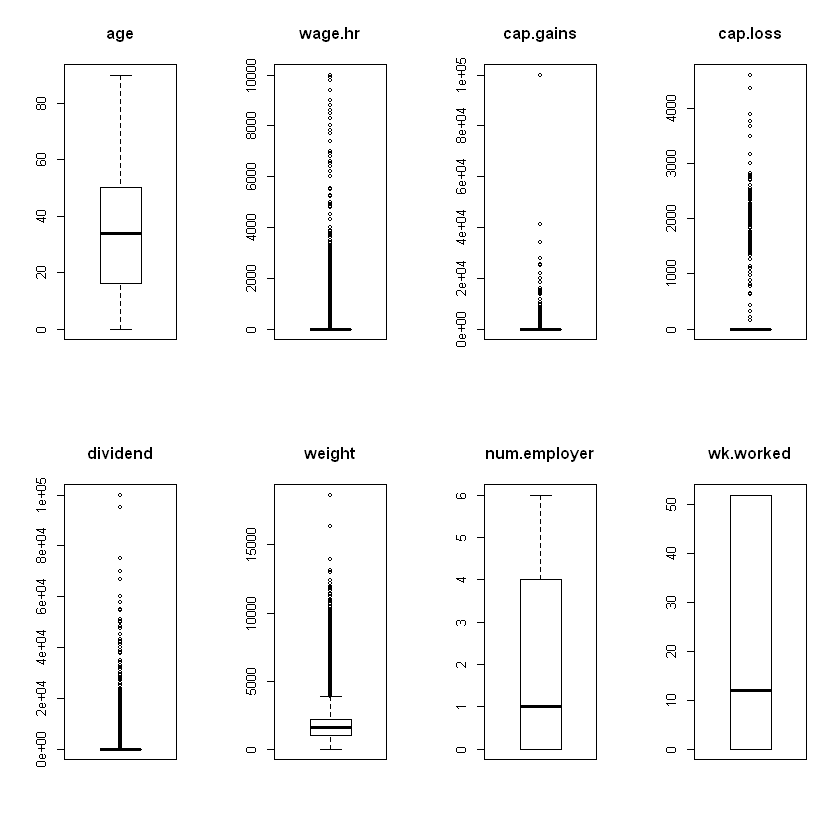

In [31]:
par(mfrow=c(2,4))
for(i in 1:8){
    boxplot(continuous[,i],main=names(continuous)[i])
}

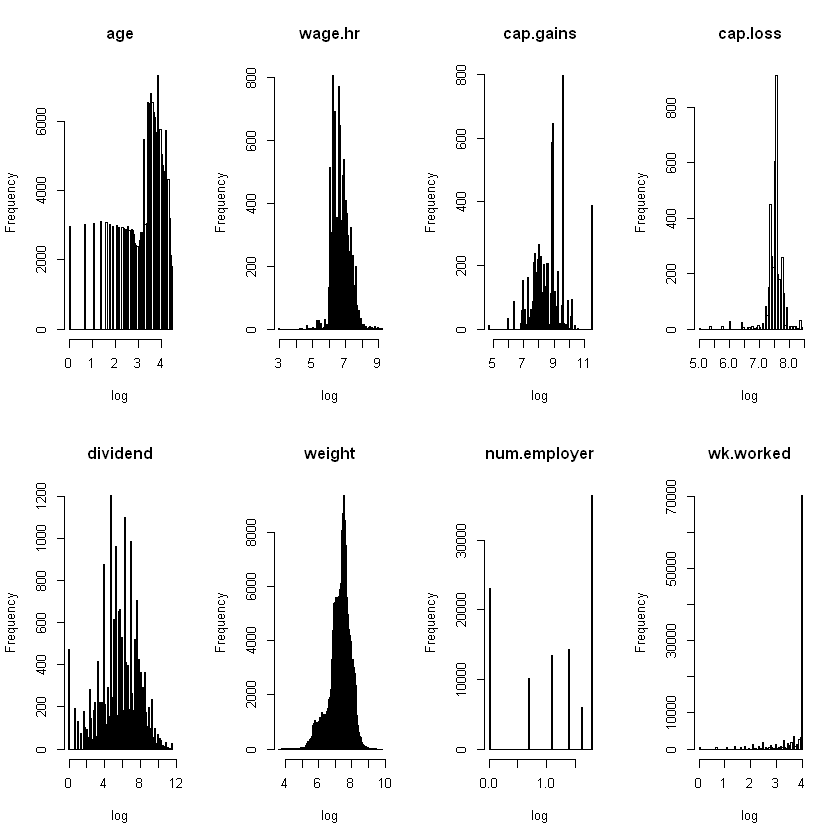

In [32]:
par(mfrow=c(2,4))
for(i in 1:8){
    hist(log(continuous[,i]),100,main=names(continuous)[i],xlab='log')
}

There are many extreme values, following skewed distributions (looks like log-normal distribution for most continuous variables). They will not be considered outliers.

Next, check for the pattern of missing values.

In [33]:
for(i in 1:41){
    if(sum(is.na(df[,i]))!=0){
        print(names(df)[i])
        print(sum(is.na(df[,i])))
    }  
}

[1] "state"
[1] 707
[1] "migration.msa"
[1] 98015
[1] "migration.reg"
[1] 98015
[1] "move.reg"
[1] 98015
[1] "sunbelt"
[1] 98015
[1] "father.nat"
[1] 6703
[1] "mother.nat"
[1] 6107
[1] "self.nat"
[1] 3389


The features migration.msa, migration.reg, move.reg, and sunbelt have the exact same number of missing values.

In [34]:
sum(is.na(df$migration.msa)*is.na(df$migration.reg)*is.na(df$move.reg)*is.na(df$sunbelt))

[1] 98015

The missing values for those 4 features are all associated with the same samples.

In [35]:
summary(df[is.na(df[,26]),])

      age                                 class.worker      industry    
 Min.   : 0.00    Not in universe               :48344   0      :48558  
 1st Qu.:16.00    Private                       :36102   33     : 8419  
 Median :34.00    Self-employed-not incorporated: 4156   43     : 4207  
 Mean   :35.05    Local government              : 3880   4      : 3035  
 3rd Qu.:50.00    State government              : 2135   42     : 2357  
 Max.   :90.00    Self-employed-incorporated    : 1602   45     : 2329  
                 (Other)                        : 1796   (Other):29110  
   occupation                             edu           wage.hr       
 0      :48558    High school graduate      :24031   Min.   :   0.00  
 2      : 4459    Children                  :21965   1st Qu.:   0.00  
 26     : 3910    Some college but no degree:13859   Median :   0.00  
 19     : 2716    Bachelors degree(BA AB BS):10092   Mean   :  57.01  
 29     : 2510    7th and 8th grade         : 3985   3rd Qu.:

Additionally, these sames have 'Not in universe' as the level for region, state, yr.house and are all from 1995 data. If included in the model, all these features must be imputed from other features using a model based on 1994 data.

## Data Visualization

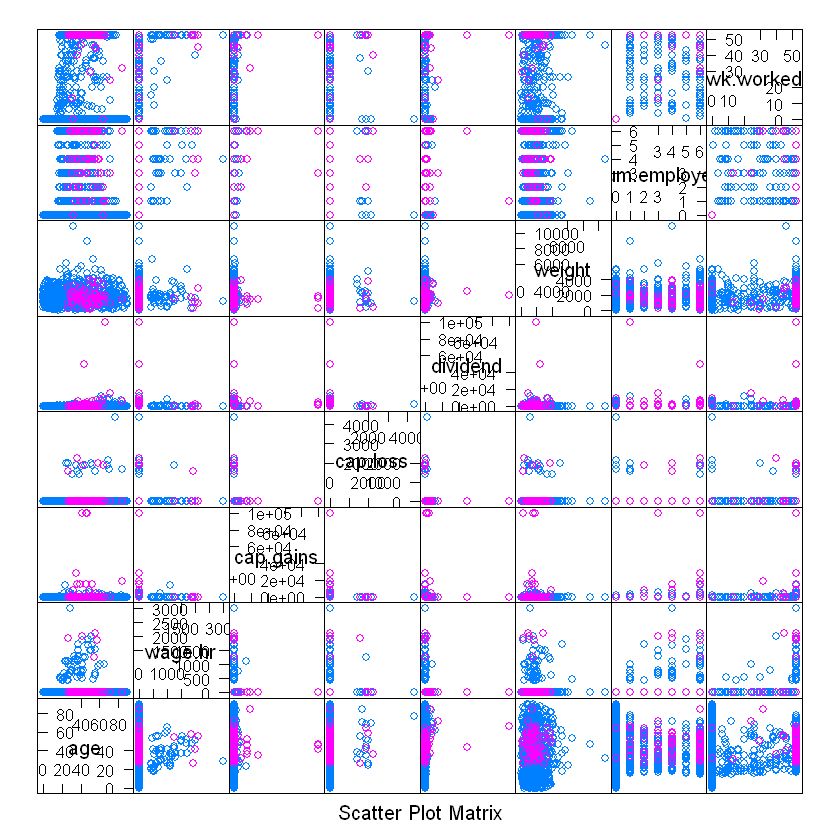

In [36]:
plotsamples <- sample(1:180000,1000)
featurePlot(continuous[plotsamples,],df[plotsamples,'income'],plot='pairs')

The pairs plots show that the distribution of high income individuals is different than that of low income individuals, however the two distributions overlap.

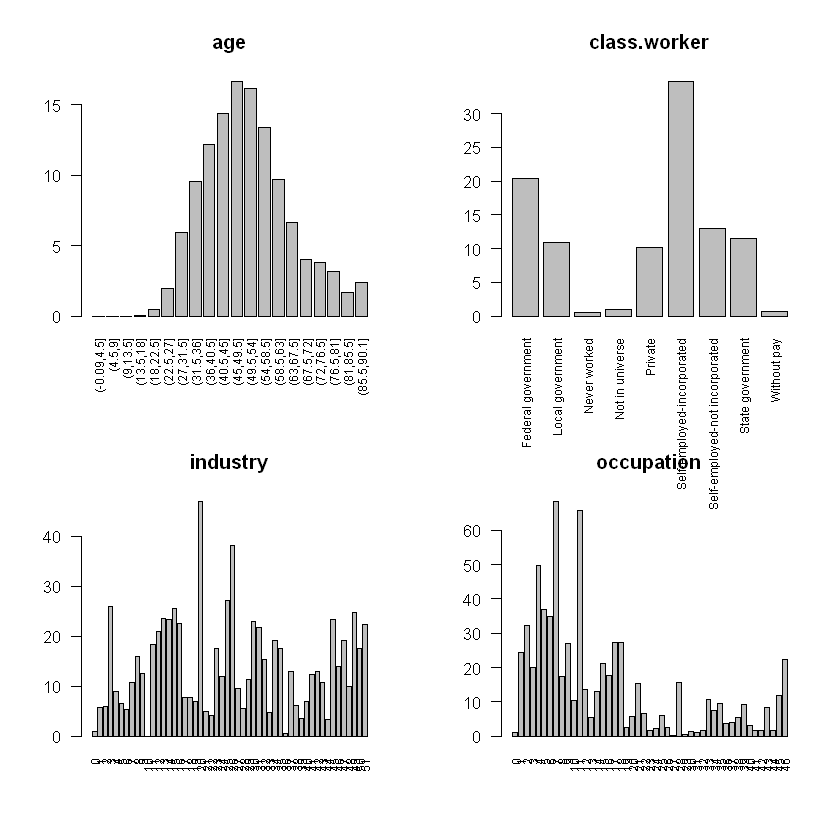

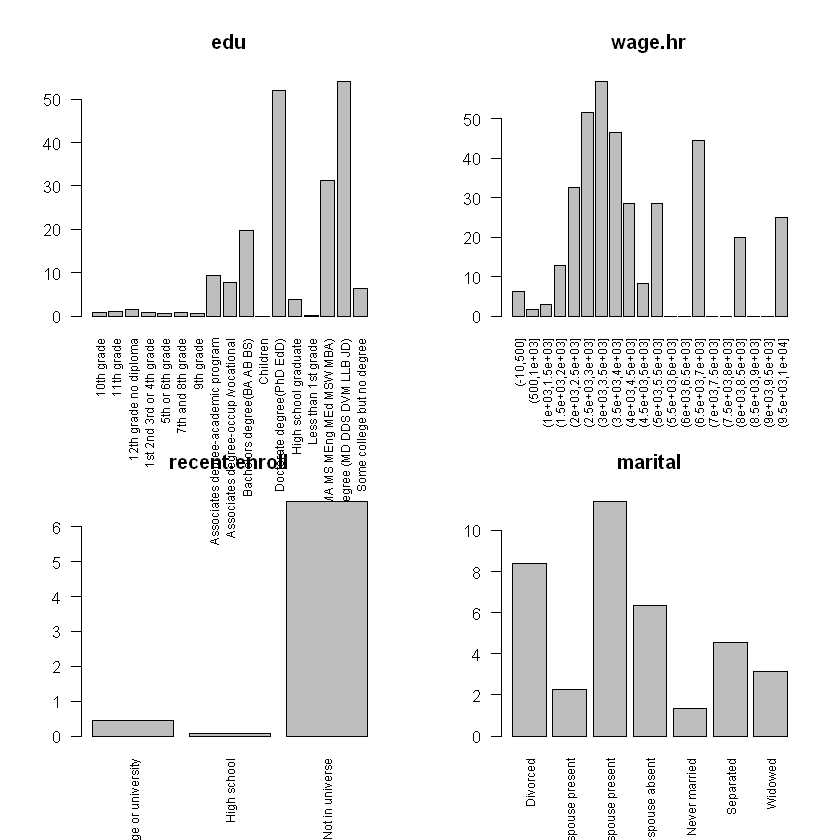

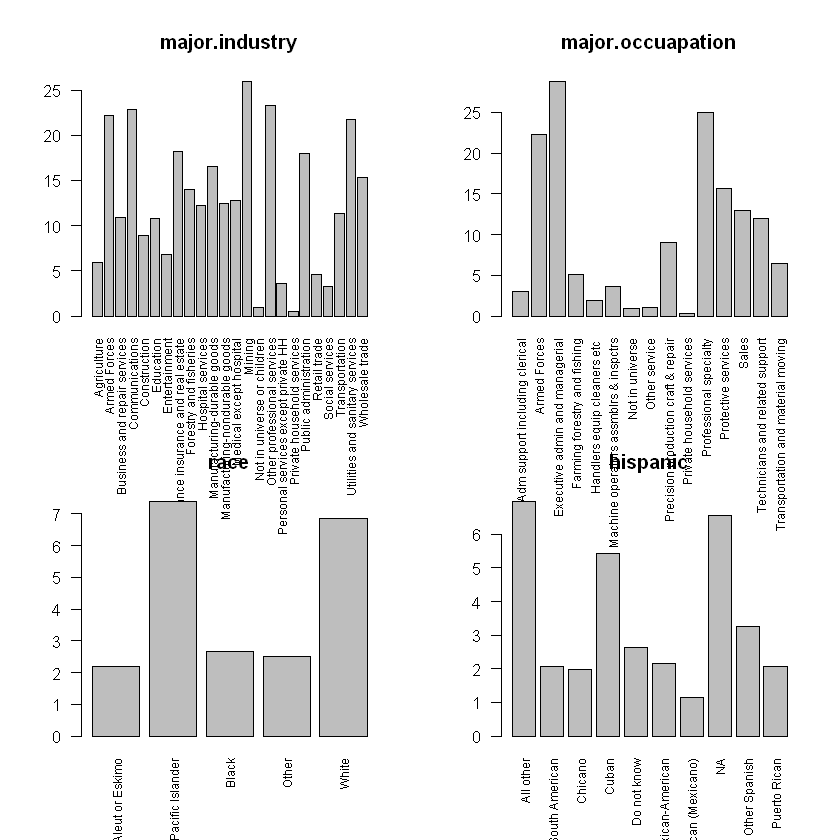

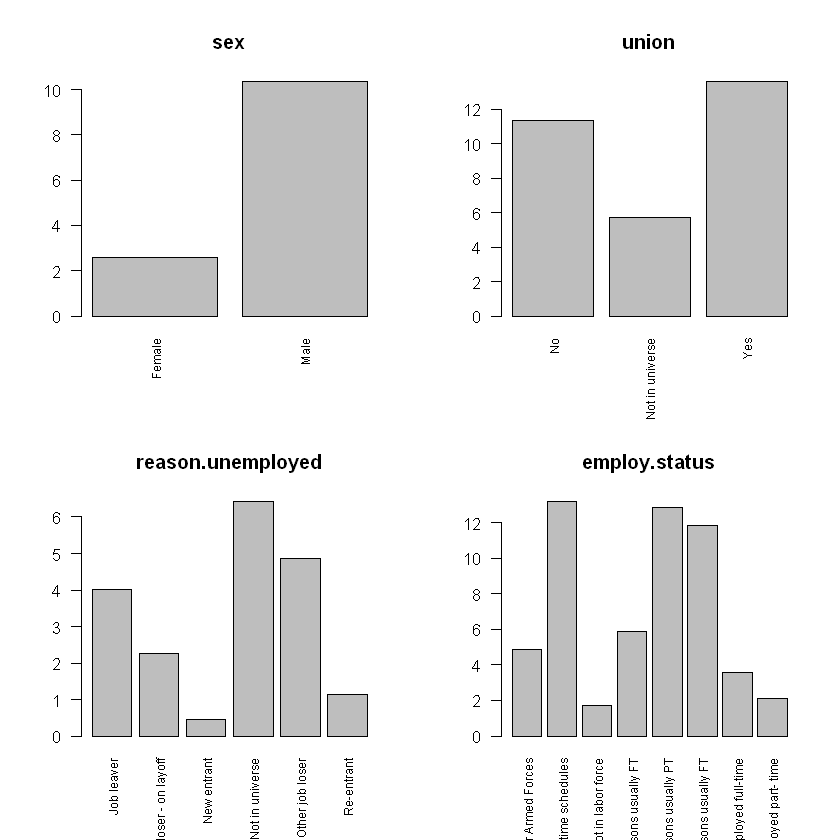

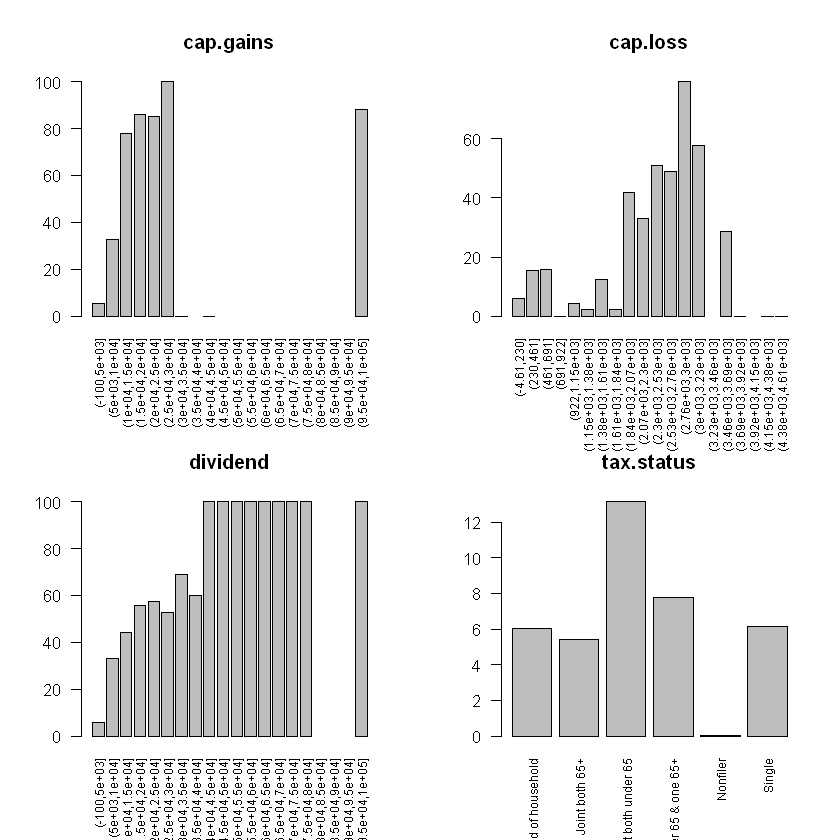

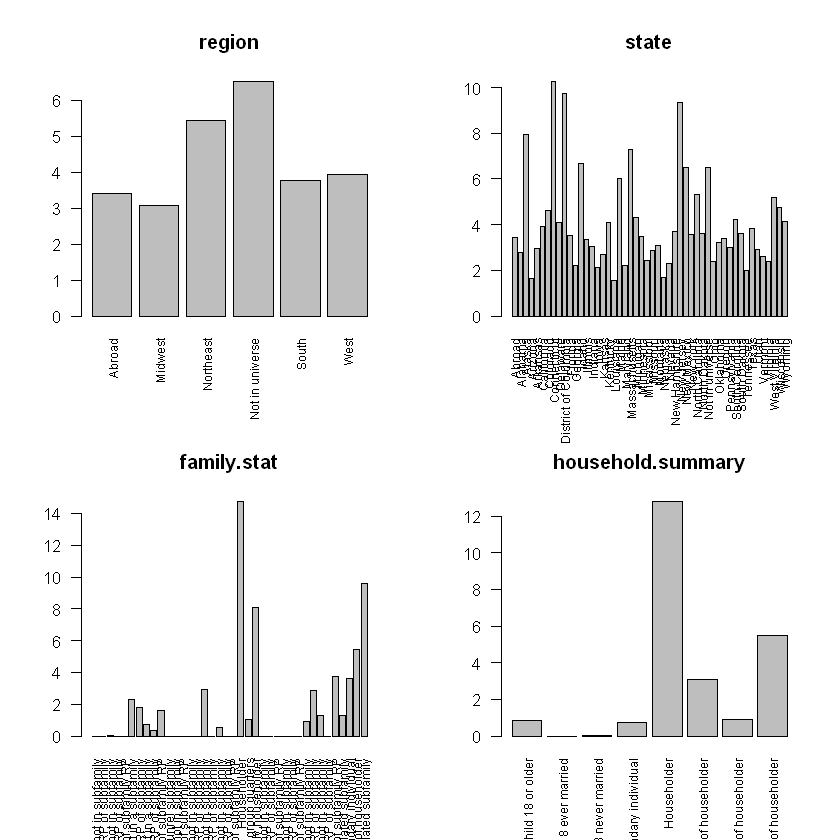

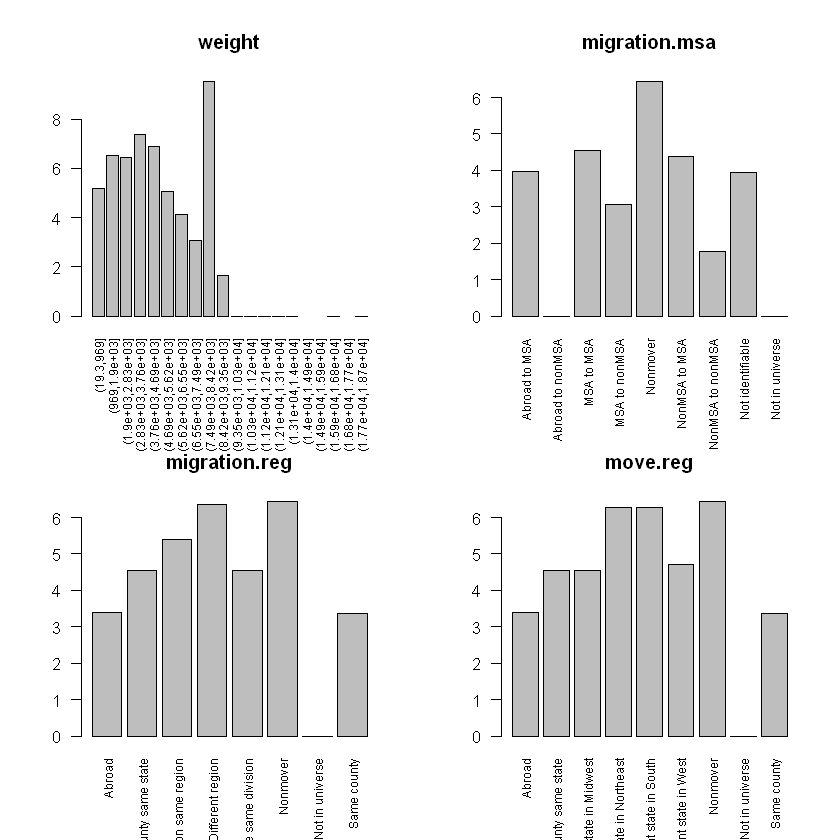

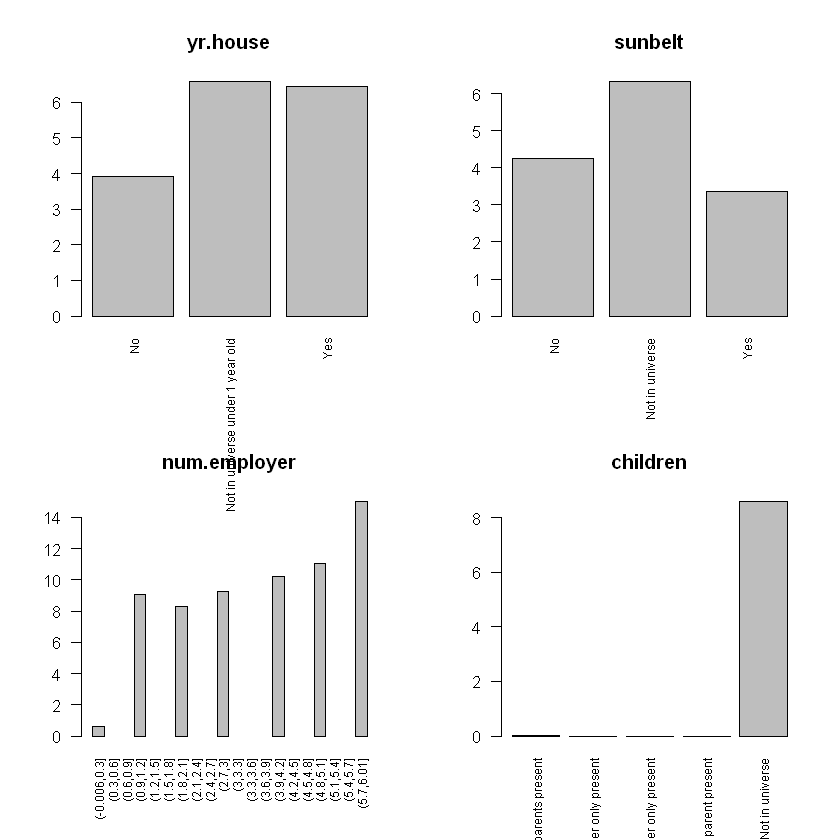

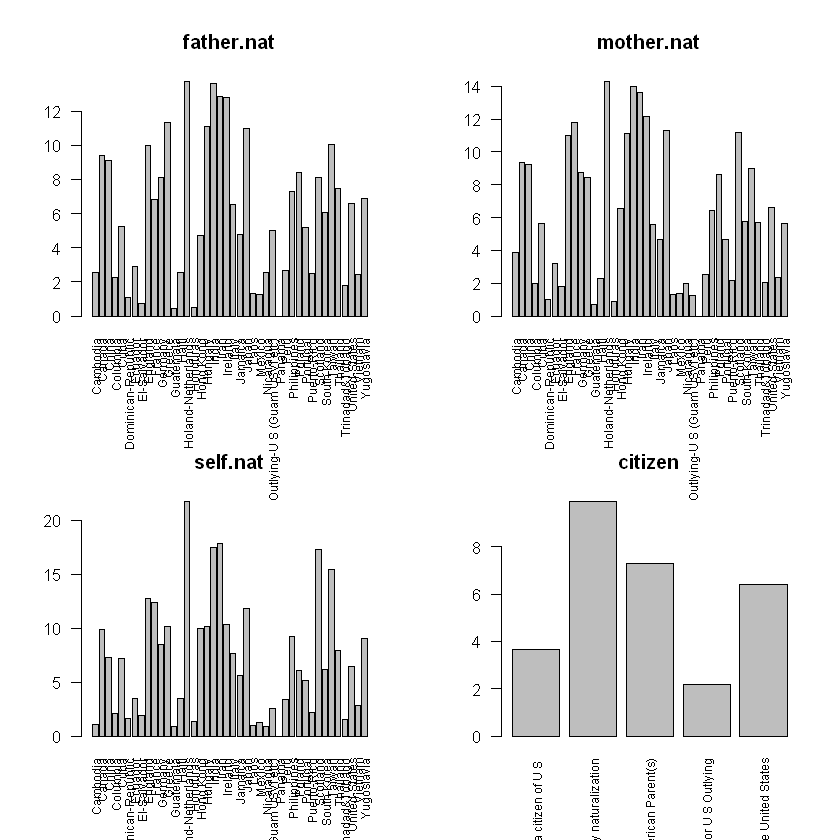

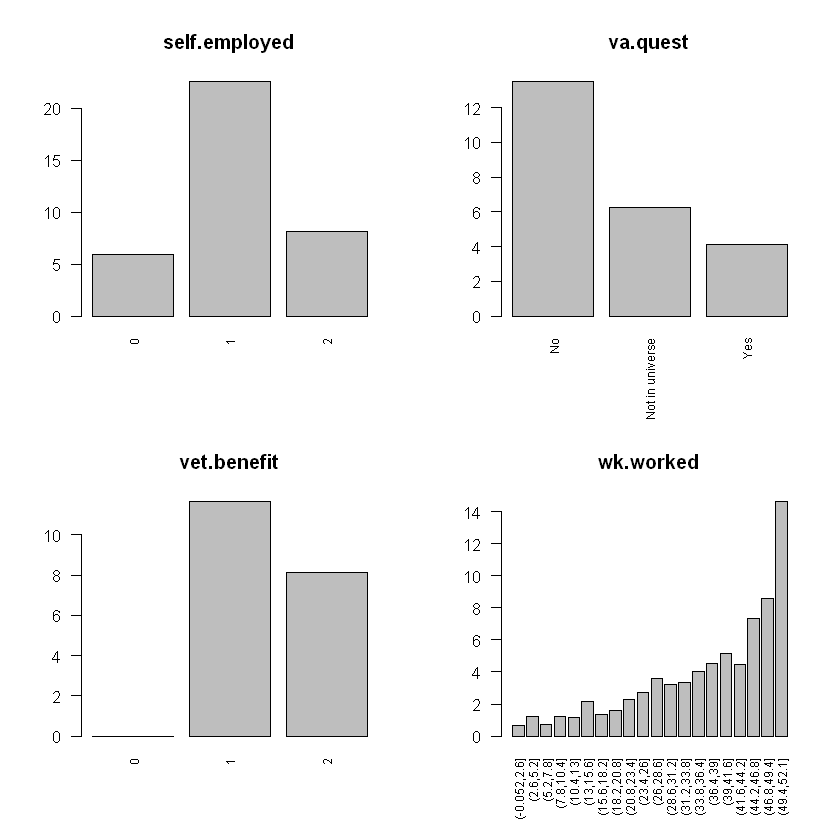

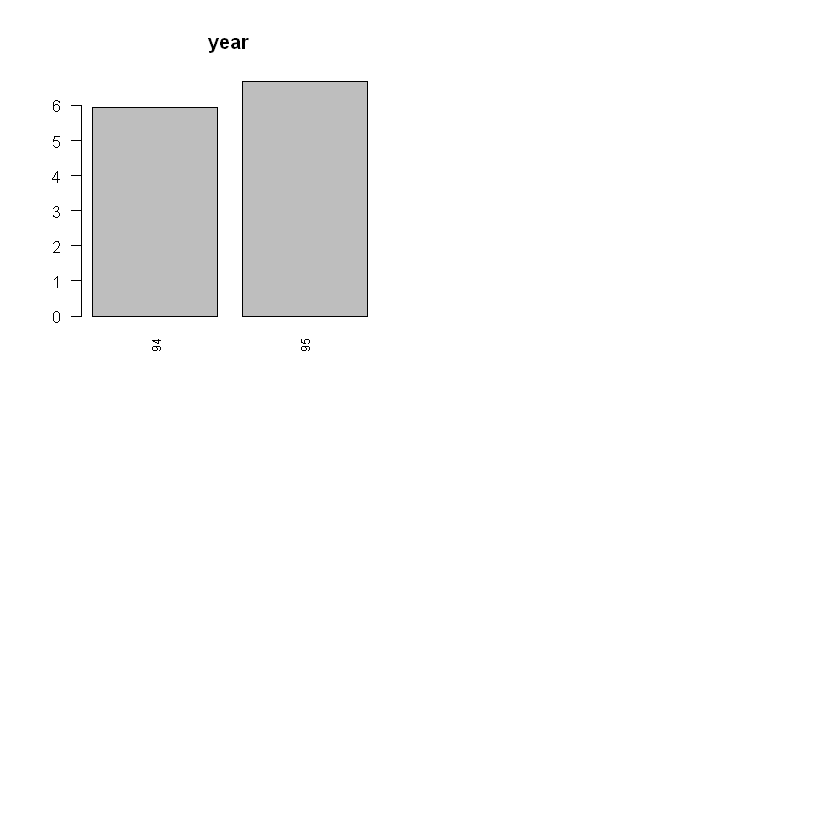

In [37]:
par(mfrow=c(2,2))
for(i in 1:41){
    if(is.factor(df[,i])) barplot(table(df[df[,42]==' 50000+.',i])/table(df[,i])*100,main=names(df)[i],cex.names=0.7,las=2)
    else{
        df$cutdf <- cut(df[,i],20)
        barplot(table(df[df[,42]==' 50000+.','cutdf'])/table(df[,'cutdf'])*100,,main=names(df)[i],cex.names=0.7,las=2)
    } 
}
df <- df[,1:42]

The plots of percent high income individuals show that income does vary noticeably across most features. Therefore there is no basis to exclude any feature yet.

## Exporting Data for Imputation Modeling

Create dummies.

In [38]:
dummy <- dummyVars(income~.,df[,-c(21:22,26:28,30)],fullRank=TRUE)
X <- predict(dummy,df[,-c(21:22,26:28,30)])
dimnames(X)[[2]] <- gsub(' ','',dimnames(X)[[2]])
head(X,5)

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'income' is not a factor"

,age,class.worker.Localgovernment,class.worker.Neverworked,class.worker.Notinuniverse,class.worker.Private,class.worker.Self-employed-incorporated,class.worker.Self-employed-notincorporated,class.worker.Stategovernment,class.worker.Withoutpay,industry.1,...,citizen.Native-BorninPuertoRicoorUSOutlying,citizen.Native-BornintheUnitedStates,self.employed.1,self.employed.2,va.quest.Notinuniverse,va.quest.Yes,vet.benefit.1,vet.benefit.2,wk.worked,year.95
1,73,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
2,58,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,52,0
3,18,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,9,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
5,10,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


Exporting data for further processing in another notebook.

In [39]:
write.csv(df,'C:/Datasets/censusincomedf.csv')

y94 <- df[df$year =='94',c(21:22,26:28,30)]
X94 <- X[X[,'year.95']==0,-391]
X95 <- X[X[,'year.95']==1,-391]
write.csv(X94,'C:/Datasets/censusincomeX94.csv')
write.csv(y94,'C:/Datasets/censusincomey94.csv')
write.csv(X95,'C:/Datasets/censusincomeX95.csv')